## Sparsity experiment

In [2]:
import torch
import numpy as np

from datasets.dataset import transform_dataset, kfold_dataset
from R2Ntab import train as train_r2ntab, R2Ntab
from DRNet import train as train_drnet, DRNet

import sys

import matplotlib.pyplot as plt
import numpy as np

In [3]:
DRNetFinalRules = []
DRNetRulesOverTime = []
DRNetAccus = []
DRNetRuleConditions = []
R2NTabFinalRules = []
R2NTabRulesOverTime = []
R2NTabAccus = []
R2NTabRuleConditions = []

# Read datasets
for name in ['adult', 'heloc', 'house', 'magic']:
    X, Y, X_headers, Y_headers = transform_dataset(name, method='onehot-compare', negations=False, labels='binary')
    datasets = kfold_dataset(X, Y, shuffle=1)
    X_train, X_test, Y_train, Y_test = datasets[0]
    train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
    test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))
    
    # Train DR-Net
    # Default learning rate (1e-2), and_lam (1e-2), and and_lam (1e-5) usually work the best. A large epochs number is necessary for a sparse rule set i.e 10000 epochs.
    net = DRNet(train_set[:][0].size(1), 50, 1)
    accuracies, rules = train_drnet(net, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, epochs=1000, batch_size=400,
                and_lam=1e-2, or_lam=1e-5, num_alter=500, track_performance=True)
    
    rule_set = net.get_rules(X_headers)
    DRNetRulesOverTime.append(rules)
    DRNetFinalRules.append(len(rule_set))
    DRNetAccus.append(accuracies)
    DRNetRuleConditions.append(sum(map(len, rule_set)))
    
    # Train R2N-tab
    # Default learning rate (1e-2), and_lam (1e-2), and and_lam (1e-5) usually work the best. 
    net = R2Ntab(train_set[:][0].size(1), 50, 1, 1)
    accuracies, rules = train_r2ntab(net, train_set, test_set=test_set, device='cpu', lr_cancel=1e-2, lr_rules=1e-2, epochs=1000, batch_size=400,
                                     and_lam=1e-2, or_lam=1e-5, cancel_lam=1, num_alter=500, track_performance=True)
    
    rule_set = net.get_rules(X_headers)
    R2NTabRulesOverTime.append(rules)
    R2NTabFinalRules.append(len(rule_set))
    R2NTabAccus.append(accuracies)
    R2NTabRuleConditions.append(sum(map(len, rule_set)))

Epoch: 100%|██████████| 1000/1000 [08:19<00:00,  2.00it/s, rules cancelled=73, loss=0.712, epoch accu=0.816, test accu=0.825, num rules=28, sparsity=0.902]


# Rule set sparsity experiment
## DRNet vs R2NTab

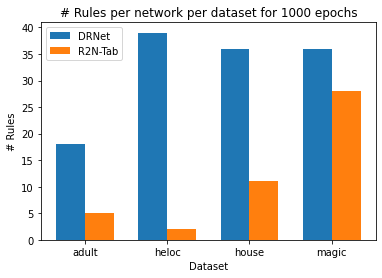

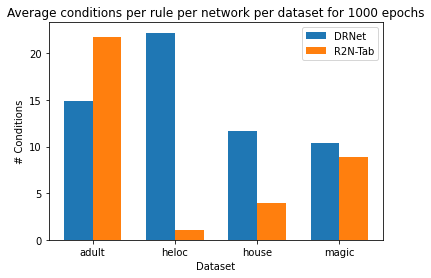

In [4]:
data = np.stack((DRNetFinalRules, R2NTabFinalRules), axis=1)

labels = ['adult', 'heloc', 'house', 'magic']
legend_labels = ['DRNet', 'R2N-Tab']

x_positions = np.arange(len(labels))

bar_width = 0.35

fig, ax = plt.subplots()
for i in range(data.shape[1]):
    ax.bar(x_positions + i * bar_width, data[:, i], bar_width, label=legend_labels[i])

ax.set_xlabel('Dataset')
ax.set_ylabel('# Rules')
ax.set_title('# Rules per network per dataset for 1000 epochs')

ax.set_xticks(x_positions + bar_width / 2)
ax.set_xticklabels(labels)

ax.legend()

plt.show()

DRNetRuleConditions = np.array(DRNetRuleConditions)
DRNetFinalRules = np.array(DRNetFinalRules)
R2NTabRuleConditions = np.array(R2NTabRuleConditions)
R2NTabFinalRules = np.array(R2NTabFinalRules)

data = np.stack((DRNetRuleConditions / DRNetFinalRules, R2NTabRuleConditions / R2NTabFinalRules), axis=1)

fig, ax = plt.subplots()
for i in range(data.shape[1]):
    ax.bar(x_positions + i * bar_width, data[:, i], bar_width, label=legend_labels[i])

ax.set_xlabel('Dataset')
ax.set_ylabel('# Conditions')
ax.set_title('Average conditions per rule per network per dataset for 1000 epochs')

ax.set_xticks(x_positions + bar_width / 2)
ax.set_xticklabels(labels)

ax.legend()

plt.show()

# Accuracy over time
## DRNet vs R2NTab

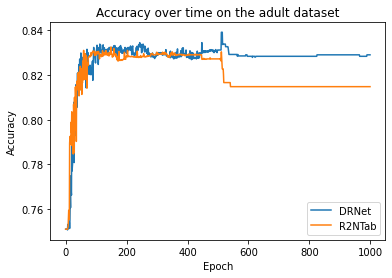

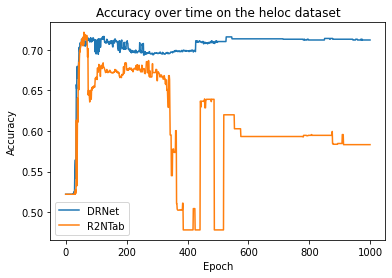

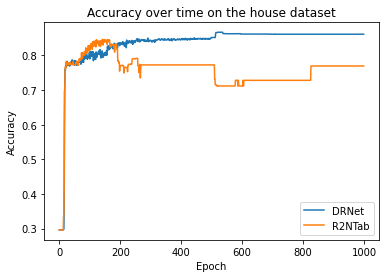

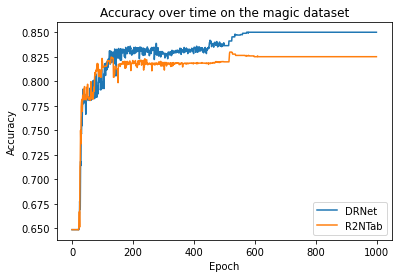

In [6]:
for index, dataset in enumerate(labels):
    plt.plot(DRNetAccus[index])
    plt.plot(R2NTabAccus[index])
    plt.title(f"Accuracy over time on the {dataset} dataset")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["DRNet", "R2NTab"])
    plt.show()

# \# Rules over time
## DRNet vs R2NTab

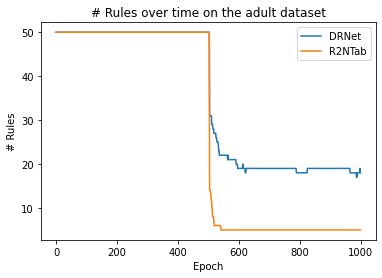

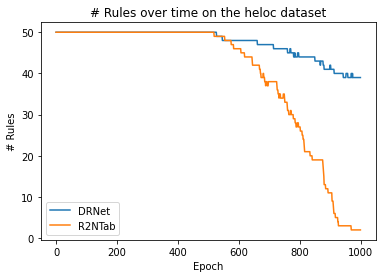

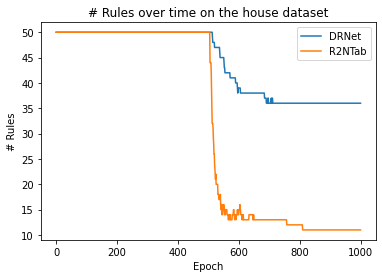

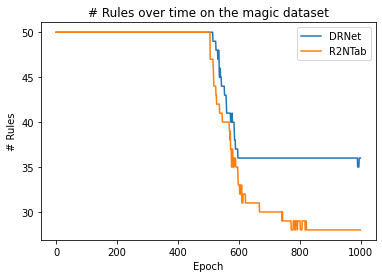

In [7]:
for index, dataset in enumerate(labels):
    plt.plot(DRNetRulesOverTime[index])
    plt.plot(R2NTabRulesOverTime[index])
    plt.title(f"# Rules over time on the {dataset} dataset")
    plt.ylabel("# Rules")
    plt.xlabel("Epoch")
    plt.legend(["DRNet", "R2NTab"])
    plt.show()  